# Kidney Images and Masks EDA
This notebook is for EDA of my training and testing files

### Import things

In [1]:
import os
import cv2
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from skimage.transform import resize

In [2]:
img_path = './train'
test_path = './test'

test_images = os.listdir(test_path)
images = os.listdir(img_path)

### Read in my csv files and poke around it

In [3]:
df = pd.read_csv('./CSVs/train.csv')
df.head()

id                                           encoding
0  2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1  aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
2  cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
3  0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
4  e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...

In [4]:
df.shape

(8, 2)

In [5]:
test = pd.read_csv('./CSVs/sample_submission.csv')
test.head()

id  predicted
0  b9a3865fc        NaN
1  b2dc8411c        NaN
2  26dc41664        NaN
3  c68fe75ea        NaN
4  afa5e8098        NaN

### Poke around and view the training and testing images:

In [6]:
#make a list of image names for training and testing sets

img_name_list = df['id'].tolist()
test_name_list = test['id'].tolist()

In [7]:
##source: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_core/py_basic_ops/py_basic_ops.html

def print_img_properties(img_id):
    path = os.path.join(img_path, img_id+'.tiff')
    image = tiff.imread(path)
    print(f'ID: {img_id} \n Image Shape:{image.shape}')
    

def print_test_properties(img_id):
    path = os.path.join(test_path, img_id+'.tiff')
    image = tiff.imread(path)
    print(f'ID: {img_id} \n Image Shape:{image.shape}')

In [8]:
#looking at image.size in training and testing sets

print('Training images:')
for names in img_name_list:
    print_img_properties(names)
print('\n')   
print('Test images:')
    
for names in test_name_list:
    print_test_properties(names)

Training images:
ID: 2f6ecfcdf 
 Image Shape:(31278, 25794, 3)
ID: aaa6a05cc 
 Image Shape:(18484, 13013, 3)
ID: cb2d976f4 
 Image Shape:(34940, 49548, 3)
ID: 0486052bb 
 Image Shape:(25784, 34937, 3)
ID: e79de561c 
 Image Shape:(1, 1, 3, 16180, 27020)
ID: 095bf7a1f 
 Image Shape:(1, 1, 3, 38160, 39000)
ID: 54f2eec69 
 Image Shape:(1, 1, 3, 30440, 22240)
ID: 1e2425f28 
 Image Shape:(1, 1, 3, 26780, 32220)


Test images:
ID: b9a3865fc 
 Image Shape:(31295, 40429, 3)
ID: b2dc8411c 
 Image Shape:(14844, 31262, 3)
ID: 26dc41664 
 Image Shape:(1, 1, 3, 38160, 42360)
ID: c68fe75ea 
 Image Shape:(1, 1, 3, 26840, 49780)
ID: afa5e8098 
 Image Shape:(36800, 43780, 3)


#### Make resizing functions

In [9]:
def resize_img(img_id, scale_percent):
        path = os.path.join(img_path, img_id+'.tiff')
        image = tiff.imread(path)
        if len(image.shape) == 5:
            image = image.squeeze().transpose(1, 2, 0)
        
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        dimensions = (width, height)
        
        resized = cv2.resize(image, dimensions)
        return resized

In [10]:
def resize_test(img_id, scale_percent):
        path = os.path.join(test_path, img_id+'.tiff')
        image = tiff.imread(path)
        if len(image.shape) == 5:
            image = image.squeeze().transpose(1, 2, 0)
        
        width = int(image.shape[1] * scale_percent)
        height = int(image.shape[0] * scale_percent)
        dimensions = (width, height)
        
        resized = cv2.resize(image, dimensions)
        return resized

In [11]:
def resize_mask(image, scale_percent):
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    dimensions = (width, height)
        
    resized = cv2.resize(image, dimensions)
    return resized

#### Resize images and display them

#### Training images:

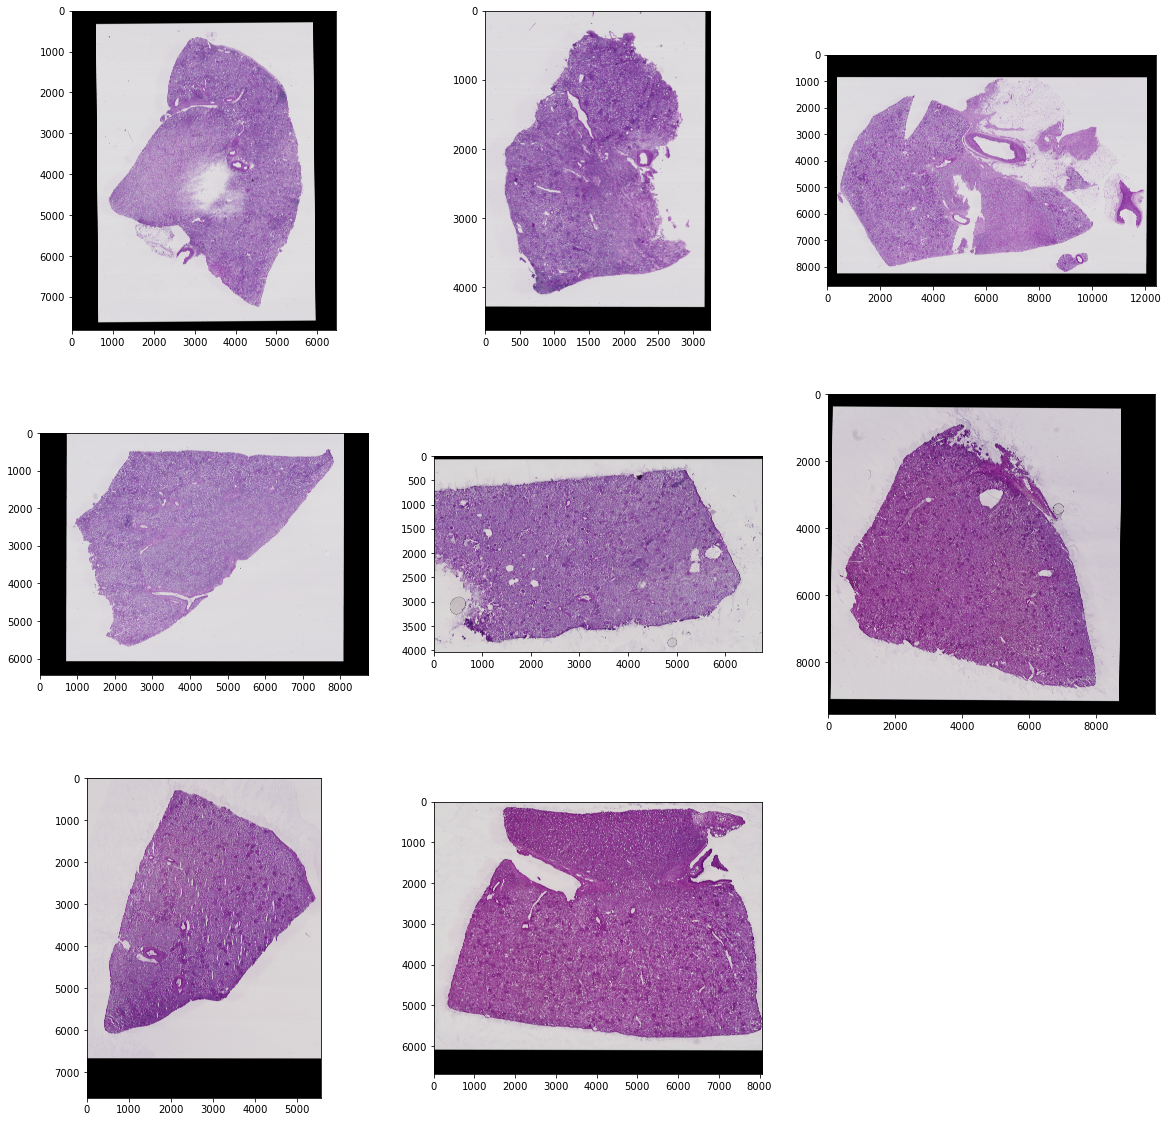

In [12]:
plt.figure(figsize=[20,20])
for i, names in enumerate(img_name_list):
    images = resize_img(names, 0.25)
    plt.subplot(3, 3, i + 1)
    plt.imshow(images)

#### Testing images:

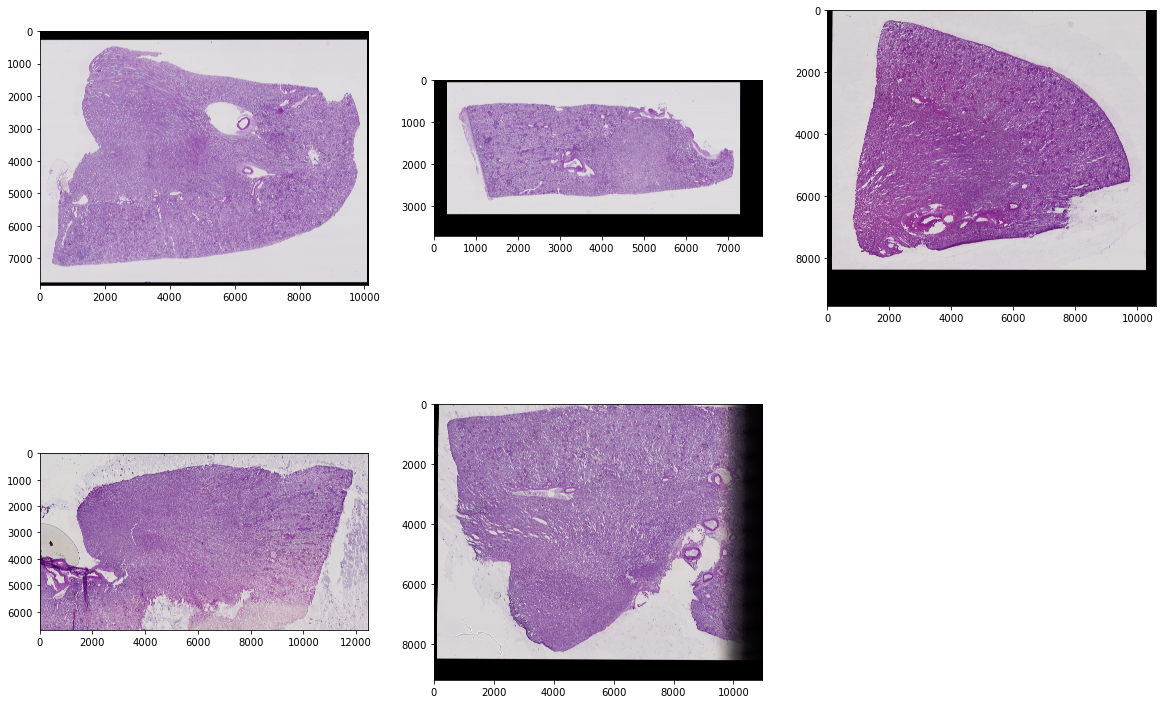

In [13]:
plt.figure(figsize=[20,20])
for i, names in enumerate(test_name_list):
    images = resize_test(names, 0.25)
    plt.subplot(3, 3, i + 1)
    plt.imshow(images)

### Visualize the masks

In [14]:
# The source for these two functions: 
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
# edited to suit my notebook

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(img_id):
    '''
    img_id: the id number of image
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    path = os.path.join(img_path, img_id+'.tiff')
    image = tiff.imread(path)
    mask_rle = df[df['id'] == img_id]['encoding'].values[0]
    
    if len(image.shape) == 5:
            image = image.squeeze().transpose(1, 2, 0)
    
    shape=(image.shape[1],image.shape[0])
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

#### Use the above function to get a numpy array for each image's "encoding" column in the df and then display the masks

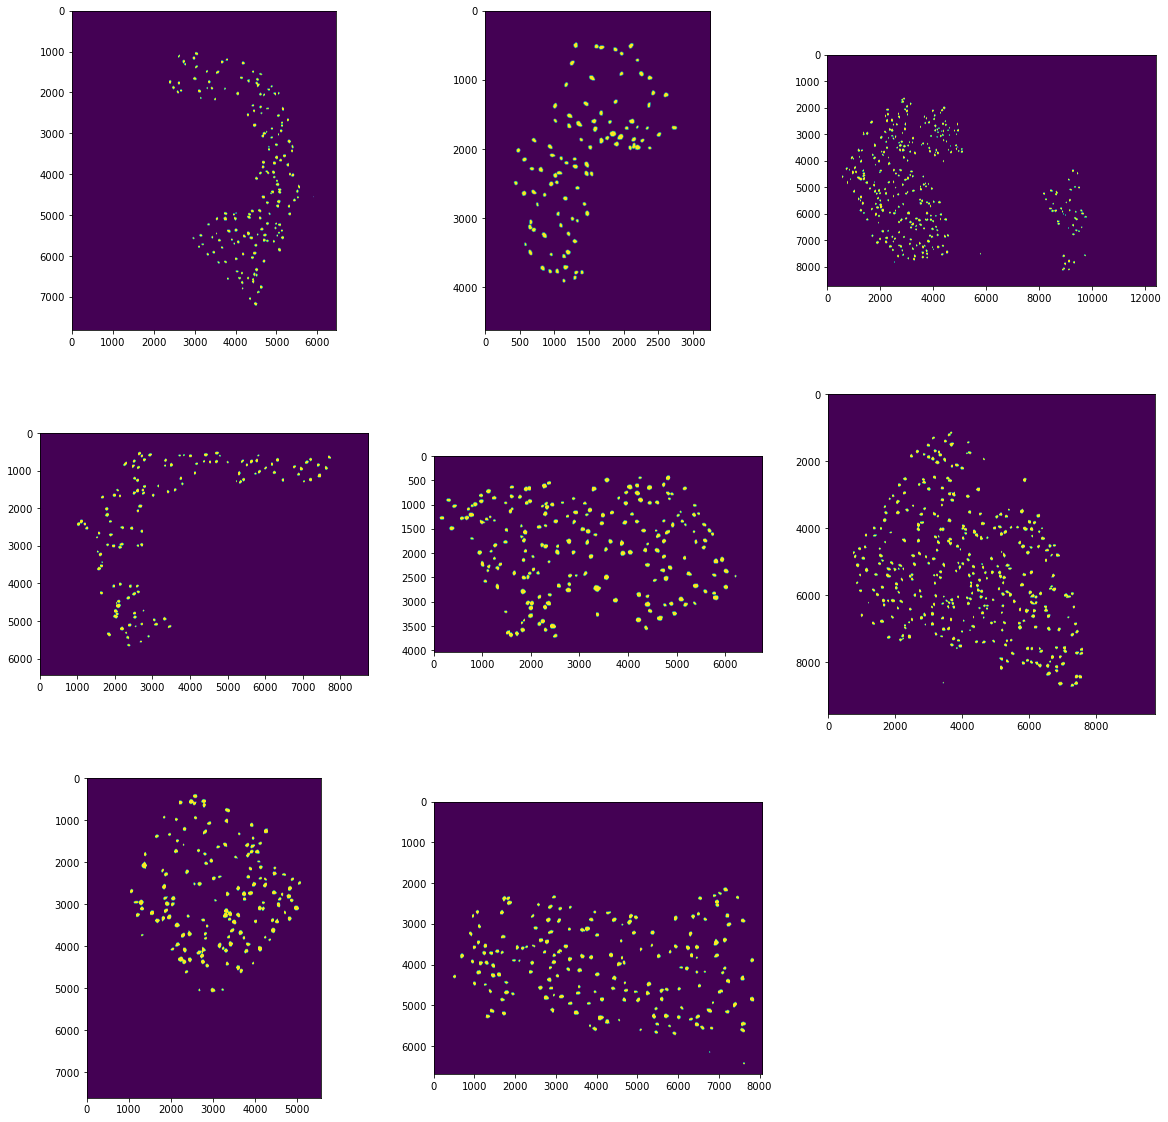

In [15]:
plt.figure(figsize=[20,20])
    
for i, names in enumerate(img_name_list):
    mask = rle2mask(names)
    resized_mask = resize_mask(mask, 0.25)
    plt.subplot(3, 3, i + 1)
    plt.imshow(resized_mask)

#### Plot the training images and the masks together

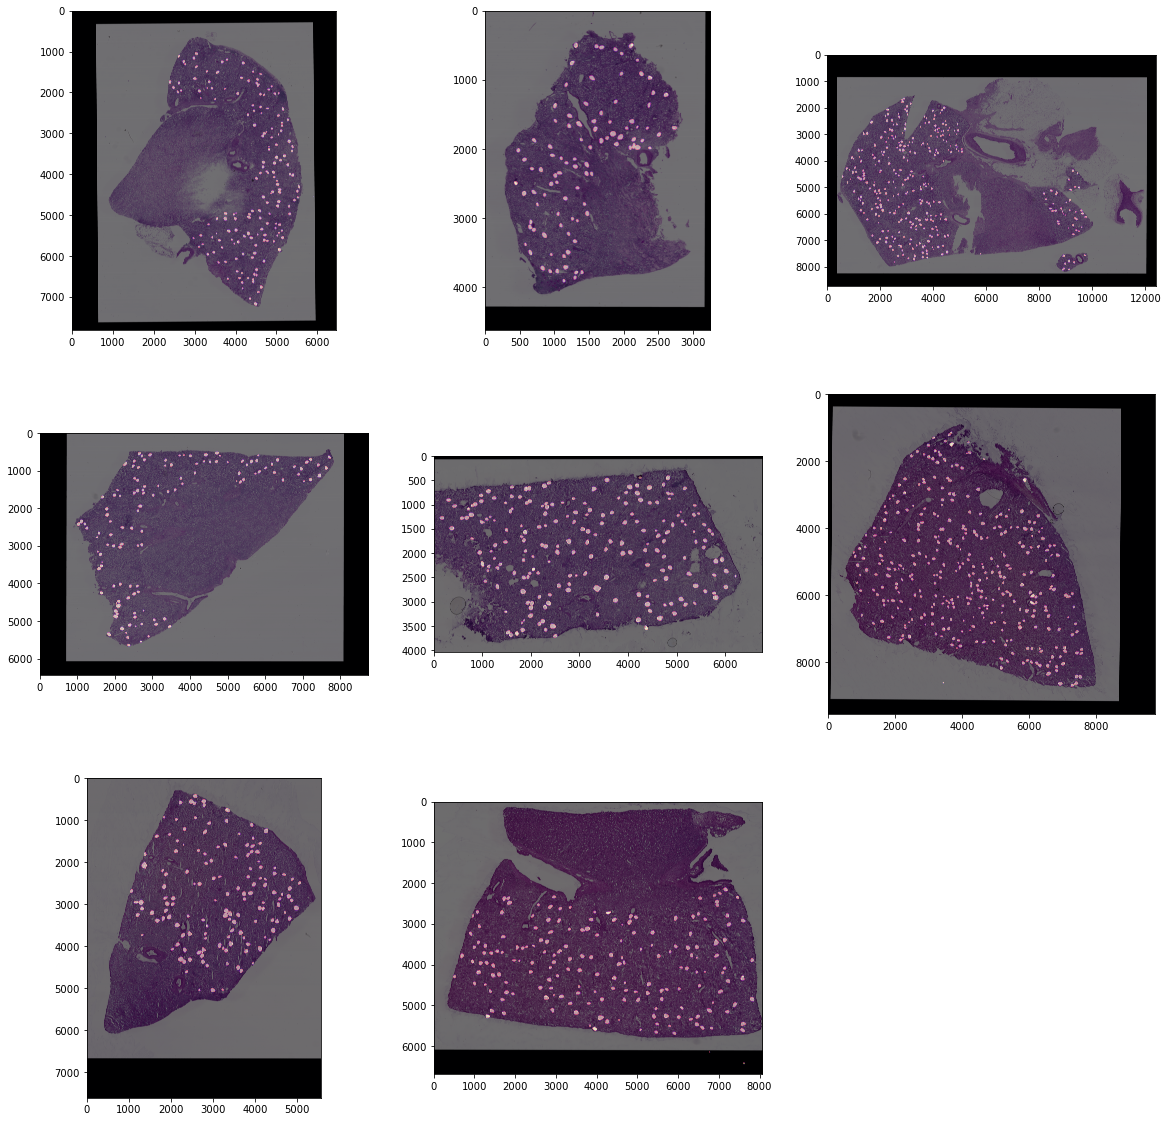

In [16]:
plt.figure(figsize=[20,20])
    
for i, names in enumerate(img_name_list):
    images = resize_img(names, 0.25)    
    mask = rle2mask(names)
    resized_mask = resize_mask(mask, 0.25)
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(images)
    plt.imshow(resized_mask, cmap='magma', alpha=0.5)

### Zooming in on an area that have a mask and an area that doesn't have a mask:
Visualizing the differences between the target and non-target cells

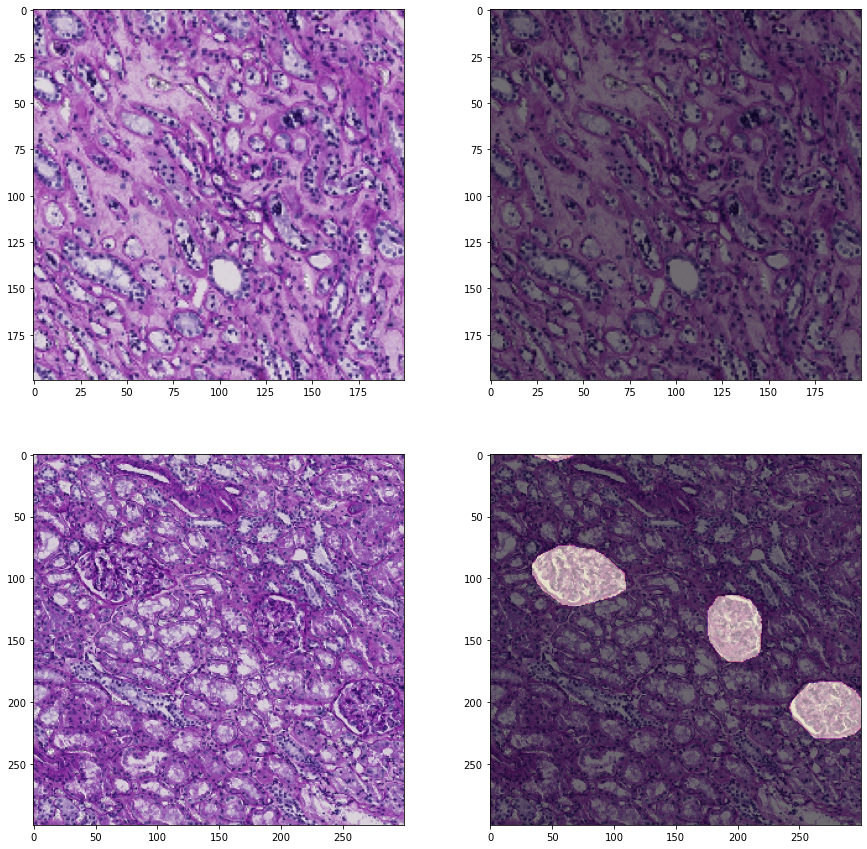

In [17]:
plt.figure(figsize=[15,15])
path = os.path.join(img_path, 'aaa6a05cc'+'.tiff')
image = tiff.imread(path)

images = resize_img('aaa6a05cc', 0.25)    
mask = rle2mask('aaa6a05cc')
resized_mask = resize_mask(mask, 0.25)

zoom_img = images[2000:2300, 900:1200, :]
zoom_mask = resized_mask[2000:2300, 900:1200]

zoom_notarget = images[3000:3200, 2000:2200, :]
zoom_notarget_mask = resized_mask[3000:3200, 2000:2200]


plt.subplot(2, 2, 1)
plt.imshow(zoom_notarget)
plt.subplot(2, 2, 2)
plt.imshow(zoom_notarget)
plt.imshow(zoom_notarget_mask, cmap='magma', alpha=0.5)

plt.subplot(2, 2, 3)
plt.imshow(zoom_img)
plt.subplot(2, 2, 4)
plt.imshow(zoom_img)
plt.imshow(zoom_mask, cmap="magma", alpha=0.5)